In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contextily as ctx
import pyproj
from shapely.geometry import Point, LineString
from zipfile import ZipFile, Path
import datetime
from matplotlib.colors import TwoSlopeNorm

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
show_date_str = "2021-09-27"

# Load data

Transport NSW GTFS data is available for download from: https://opendata.transport.nsw.gov.au/node/4035/download

Requires new user registration

Code assumes file is located at following path:
`data/local_only/full_greater_sydney_gtfs_parent_TSN.zip`

In [3]:
with ZipFile("data/local_only/full_greater_sydney_gtfs_parent_TSN.zip") as myzip:
    stops_df = pd.read_csv(myzip.open("stops.txt"), dtype={ 'stop_id': 'str', 
        'stop_code': 'str',
        'stop_name': 'str',
        'stop_lat': 'float',
        'stop_lon': 'float',
        'location_type': 'Int64',
        'parent_station': 'str',
        'wheelchair_boarding': 'str', 
        'platform_code': 'str',})
    stops_gdf = gpd.GeoDataFrame(stops_df, 
        geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)).set_crs(epsg=4326)
    
    routes_df = pd.read_csv(myzip.open("routes.txt"), dtype={
        'route_id': 'str',  
        'agency_id': 'str',  
        'route_short_name': 'str',  
        'route_long_name': 'str', 
        'route_desc': 'str', 
        'route_type': 'Int64',
        'route_color': 'str',  
        'route_text_color': 'str', 
        'exact_times': 'bool'
    })
    
    trips_df = pd.read_csv(myzip.open("trips.txt"), dtype={
        'route_id': 'str', 
        'service_id': 'str',  
        'trip_id': 'str',
        'shape_id': 'str', 
        'trip_headsign': 'str', 
        'direction_id': 'str',  
        'block_id': 'str', 
        'wheelchair_accessible': 'str', 
        'route_direction': 'str', 
        'trip_note': 'str', 
        'bikes_allowed': 'str'
    })
    
    stop_times_df = pd.read_csv(myzip.open("stop_times.txt"), dtype={
        'trip_id': 'str',
        'arrival_time': 'str',
        'stop_id': 'str', 
        'departure_time': 'str', 
        'stop_id': 'str',
        'stop_sequence': 'Int64',
        'stop_headsign': 'str',
        'pickup_type': 'Int64',
        'drop_off_type': 'Int64',
        'shape_dist_traveled': 'float',
        'timepoint': 'bool',
        'stop_note': 'str',
    }).astype({})
    
    agency_df = pd.read_csv(myzip.open("agency.txt"), dtype={
        'agency_id': 'str', 
        'agency_name': 'str', 
        'agency_url': 'str',  
        'agency_timezone': 'str',
        'agency_lang': 'str', 
        'agency_phone': 'str',
    })
    
    shapes_df = pd.read_csv(myzip.open("shapes.txt"), dtype={
        'shape_id': 'str', 
        'shape_pt_lat': 'float', 
        'shape_pt_lon': 'float',  
        'shape_pt_sequence': 'Int64', 
        'shape_dist_traveled': 'float',
    })
    shapes_gdf = gpd.GeoDataFrame(shapes_df, 
        geometry=gpd.points_from_xy(shapes_df.shape_pt_lon, shapes_df.shape_pt_lat)).set_crs(epsg=4326)
    
    calendar_df = pd.read_csv(myzip.open("calendar.txt"), dtype={
        'service_id': 'str',  
        'monday': 'bool',  
        'tuesday': 'bool',  
        'wednesday': 'bool',  
        'thursday': 'bool',  
        'friday': 'bool', 
        'saturday': 'bool',  
        'sunday': 'bool',  
        'start_date': 'str', 
        'end_date': 'str',
    })
    
    calendar_dates_df = pd.read_csv(myzip.open("calendar_dates.txt"), dtype={
        'service_id': 'str',  
        'date': 'str',
        'exception_type': 'Int64',
    })

# Find services running on that date

In [4]:
date = datetime.datetime.strptime(show_date_str, "%Y-%m-%d")
date_string = date.strftime("%Y%m%d")
day_of_week_name = date.strftime('%A').lower()

services_for_day_1 = calendar_df[(calendar_df[day_of_week_name]) & (date_string >= calendar_df.start_date) & (date_string <= calendar_df.end_date)].service_id.to_numpy()
print(f"scheduled for day based on calendar: {len(services_for_day_1)}")

# exception_type
# 1 - Service has been added for the specified date.
# 2 - Service has been removed for the specified date.
services_added_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 1)].service_id.to_numpy()
services_removed_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 2)].service_id.to_numpy()
print(f"services added using calendar_dates: {len(services_added_for_day)}")
print(f"services removed using calendar_dates: {len(services_removed_for_day)}")

services_for_day_2 = np.concatenate([services_for_day_1, services_added_for_day])

services_for_day = np.setdiff1d(services_for_day_2, services_removed_for_day)

print(f"final services for day: {len(services_for_day)}")

scheduled for day based on calendar: 1493
services added using calendar_dates: 5
services removed using calendar_dates: 900
final services for day: 598


# Get each route segment with start and end coordinates and sequence

In [5]:
coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
coords_roll_1 = np.roll(coords, 1, axis=0)

segments = pd.DataFrame(np.concatenate([coords_roll_1, coords], axis=1), columns=["start_lat", "start_lng", "start_seq", 
                                                                       "end_lat", "end_lng", "end_seq"])
segments_df = shapes_df[["shape_id"]].join(segments)
segments_df = segments_df[segments_df.end_seq != 1]
segments_df = segments_df.drop(columns=['end_seq']).rename(columns={ "start_seq": "seq" })
segments_df

,shape_id,start_lat,start_lng,seq,end_lat,end_lng
1,1-SC0-1-sj2-3.1.R,-34.854029,150.609468,1,-34.854347,150.609301
2,1-SC0-1-sj2-3.1.R,-34.854347,150.609301,2,-34.854242,150.609039
3,1-SC0-1-sj2-3.1.R,-34.854242,150.609039,3,-34.853635,150.609369
4,1-SC0-1-sj2-3.1.R,-34.853635,150.609369,4,-34.853422,150.609489
5,1-SC0-1-sj2-3.1.R,-34.853422,150.609489,5,-34.853263,150.609572
...,...,...,...,...,...,...
7134961,9-F9-sj2-1.9.H,-33.864244,151.259225,26,-33.865068,151.259724
7134962,9-F9-sj2-1.9.H,-33.865068,151.259724,27,-33.865874,151.260159
7134963,9-F9-sj2-1.9.H,-33.865874,151.260159,28,-33.867232,151.26079
7134964,9-F9-sj2-1.9.H,-33.867232,151.26079,29,-33.869061,151.261544


# Get number of trips for each shape

In [6]:
day_trips = trips_df[trips_df.service_id.isin(services_for_day)]
sydney_bus_route_ids = routes_df[routes_df.route_desc == "Sydney Buses Network"].route_id.unique()
shape_day_trips = day_trips[day_trips.route_id.isin(sydney_bus_route_ids)].groupby(by="shape_id").size().to_frame("day_trips")
shape_day_trips

,day_trips
shape_id,
20-668-sj2-1.1.R,1
20-668-sj2-1.10.R,5
20-668-sj2-1.11.R,2
20-668-sj2-1.2.H,2
20-668-sj2-1.3.R,2
...,...
74-530-sj2-1.2.H,4
74-530-sj2-1.3.R,38
74-530-sj2-1.4.R,3


# Merge segments with day trip counts

In [7]:
shape_segments_day_trips = pd.merge(segments_df, shape_day_trips, left_on="shape_id", right_index=True)

# how many trip occurs in each segment per day
shape_segments_day_trips = pd.merge(segments_df, shape_day_trips, left_on="shape_id", right_index=True)

In [8]:
segment_day_trips = shape_segments_day_trips.groupby(by=[
    "start_lat", "start_lng", "end_lat", "end_lng"]).sum("day_trips").reset_index()

# Create LineString geometry for segment and create GeoDataFrame

In [9]:
from shapely.geometry import Point, LineString

def get_line_string(row):
    start = Point(row.start_lng, row.start_lat)
    end = Point(row.end_lng, row.end_lat)
    line = LineString([start, end])
    row["geometry"] = line
    return row

segment_day_trips_gpd = gpd.GeoDataFrame(segment_day_trips.apply(get_line_string, axis=1)).set_crs(epsg=4326)

# Plot each segment with color showing number of trips per day

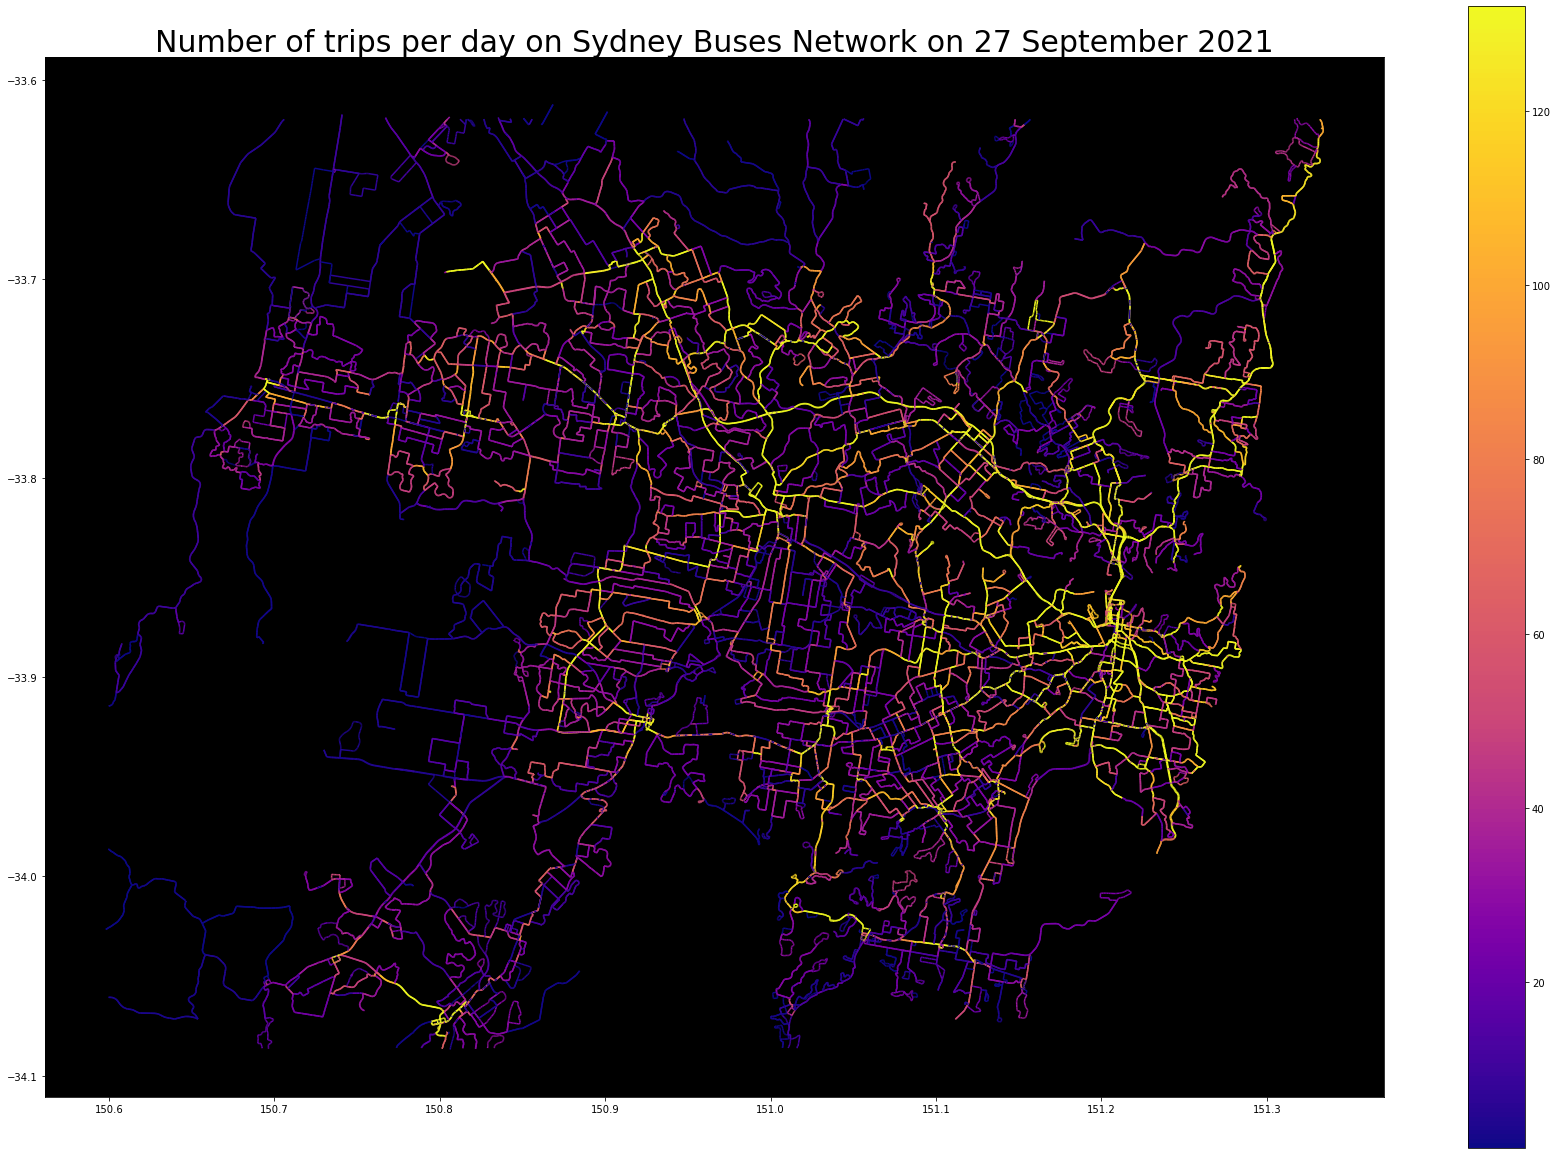

In [15]:
vmin, vmax, vcenter = segment_day_trips_gpd["day_trips"].min(), segment_day_trips_gpd["day_trips"].quantile(.90), 50
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")

def limit_to_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]

# Greater Sydney bounding box
sydney_bb = {
    "north": -33.62,
    "south": -34.086,
    "west": 150.6,
    "east": 151.38,
}

sydney_segment_day_trips_gpd = limit_to_bounding_box(segment_day_trips_gpd, sydney_bb)

sydney_segment_day_trips_gpd.plot(ax=ax, cmap="plasma", column='day_trips', legend=True, norm=norm)

ax.set_title(f"Number of trips per day on Sydney Buses Network on {date:%d %B %Y}", fontsize=30)

plt.savefig("Sydney Buses Network.jpeg")